<a href="https://colab.research.google.com/github/ywei6056/Intro.-Experimental-Physics-I-NYU/blob/main/LabAnalysis3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As in other assignments, this first code block is meant to set things up. **Below, modify the ```!git clone``` line so that the url points to your own data repository.**



In [ ]:
# necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import scipy.optimize
import itertools,operator
import copy
from sklearn.utils import Bunch

# MODIFY THIS LINE SO THAT THE URL POINTS TO YOUR DATA REPOSITORY
!git clone https://github.com/NYU-IEP-2022-3-Classroom/lab3-data-repository-ywei6056

#this line makes sure you followed the direction above; if you see 20 copies of "you didn't change the directory to match your name!" that means you need to update the data repository name and clone again
#delete my data repository (use folder icon on the left) or you will get this message again
if os.path.isdir('lab3-data-repository-mgershow'):
  for i in range(20):
    print ("You didn't change the directory to match your name!")

fatal: destination path 'lab3-data-repository-ywei6056' already exists and is not an empty directory.


These functions are needed to load the data and do a little pre-processing. Run the cell, but you don't need to change anything

In [ ]:
def findAngleFiles (startdir):
  #angleFiles = findAngleFiles(startdir)
  # input stardir: path to top level directory (e.g. data_repository/large bob)
  # output angleFiles: array with paths to angle files  
  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python

  angleFiles = sorted(glob.glob(startdir + '/**/*_angle.txt'))
  return (angleFiles)

# fitting an exponential
# exponential has two parameters, the y-intercept (a) and the
# exponential multiplier constant (b which for our purposes is -1/tau)
# uses cauchy loss function to reduce the influence of outliers
# inputs: x,y - numpy arrays
# outputs: a: fit value of y(0)
#          b: fit value of exonent
#          fity: a * e^(bx) 
def fitExponentialCauchyLoss(x,y):
  xx = x - np.min(x)
  yy = y / np.max(y)
  res = scipy.optimize.least_squares(lambda p : p[0]*np.exp(p[1] * xx)-yy,  (1, -1/max(xx)), loss = 'cauchy')
  a = res.x[0]
  b = res.x[1]
  a = a*np.max(y)*np.exp(-b*np.min(x))
  return (a,b, a*np.exp(b*x))



# load angle file and do some minor processing
# inputs: filepath - path of the file
# outputs: bunch object with fields
# number crossing number since start of experiment (a full period is 2 crossings)
# time time of crossing since start of experiment (resolution = 1us, accuracy unknown)
# majaxis major axis (in mm) from fitter
# minaxis minor axis (in mm) from fitter
# theta angle of major axis (in radians) relative to x-axis, from fitter
# slope slope of the voltage vs. time trace (in V/s) at time of crossing --  proportional to the total energy of the bob
# dnamplitude denoised amplitude (```sqrt(majaxis**2 + minaxis**2)```) (in mm)  found by fitting the amplitude to a decaying exponential using a cost-function that discards outliers
# dnmajaxis denoised major axis (see fit amplitude) (in mm)
# dnslope denoised slope (in V/s)
# filename name of the file the experiment was loaded from

def loadAngleFile(filepath, maxTime = 10000000):
  number, time, majaxis, minaxis, theta, slope = np.loadtxt(filepath, skiprows = 1, unpack = True)
  _,_,fitamplitude = fitExponentialCauchyLoss(time-time[0],np.sqrt(minaxis**2 + majaxis**2))
  _,_,fitmajaxis = fitExponentialCauchyLoss(time-time[0],majaxis)
  _,_,fitslope = fitExponentialCauchyLoss(time-time[0],slope)
  
  return(Bunch(number=number-number[0],time=time-time[0],majaxis=majaxis,dnamplitude=fitamplitude,minaxis=minaxis,theta=theta,slope=slope,dnmajaxis=fitmajaxis, dnslope=fitslope,filename=filepath))
  
def trimExperiment(oldexpt, timerange):
  expt = copy.copy(oldexpt)
  valid = np.logical_and(expt.time >= np.min(timerange), expt.time <= np.max(timerange))
  expt.time = expt.time[valid]
  expt.time = expt.time - expt.time[0]
  expt.number = expt.number[valid]
  expt.number = expt.number - expt.number[0]
  expt.majaxis = expt.majaxis[valid]
  expt.minaxis = expt.minaxis[valid]
  expt.theta = expt.theta[valid]
  expt.slope = expt.slope[valid] 
  _,_,expt.dnamplitude = fitExponentialCauchyLoss(expt.time,np.sqrt(expt.minaxis**2 + expt.majaxis**2))
  _,_,expt.dnmajaxis = fitExponentialCauchyLoss(expt.time,expt.majaxis)
  _,_,expt.dnslope = fitExponentialCauchyLoss(expt.time,expt.slope)
  return expt


##Analyze the data you collected using the crossing counter panel
1. Below, enter the rms amplitude and the period for each measurement. Note that if you made measurements on multiple days, *you cannot simply combine them.* Repeat the analysis for both days separately
1. Calcualte the length of your pendulum using $L = g*(T/(2 \pi))^2$ and g = 9802 mm/s$^2$ so that 
1. Make a scatter plot of the period vs. $(a/L)^2$ 
1. Use ```np.polyfit(___,___,1)``` to fit the period to a line of the form $T = T_0 + m (a/L)^2$ and plot the result on the same axes. If you write `p = np.polyfit...)`, then `p[0]` is m and `p[1]` is T
1. According to our model, $T_0/m$ should equal 16. Print your result for this value.

Average L=1.0667571710447652


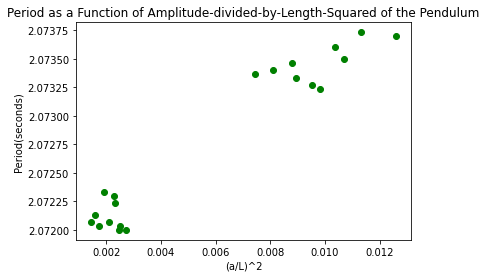

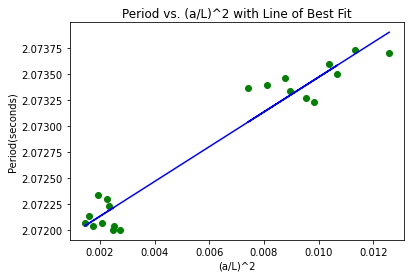

12.376425790990124


In [ ]:
from numpy.core.fromnumeric import size
#enter the amplitude and periods in the same order, so that period[0] is the period of the measurement with amp[0], period[1] is the period of the measurement with amp[1] etc
amp = [119.673, 113.521, 108.622, 104.12, 99.9987, 96.009, 91.9082, 110.27, 105.745, 100.962, 55.8144, 53.0735, 50.8429, 48.7712, 46.7683, 44.5529, 42.6389, 40.5624, 53.3641, 51.326] #you fill in this list
period = [62.211, 62.212, 62.208, 62.198, 62.204, 62.202, 62.201, 62.205, 62.197, 62.200, 62.160, 62.16, 62.169, 62.162, 62.17, 62.161, 62.164, 62.162, 62.161, 62.167] #you fill in this list 

amp = np.array(amp)/1000
#print(amp)
period=np.array(period)/30

L = 9.802*(np.mean(period)/(np.pi*2))**2
print("Average L={}".format(L))


# make a plot of period (y-axis) vs. (a/L)^2 (x-axis). Hint: store (a/L)^2 in a variable - you'll use it later
y = period
x = (amp/L)**2
#print(x)
plt.plot(x,y, 'go')
plt.xlabel('(a/L)^2')
plt.ylabel('Period(seconds)')
plt.title('Period as a Function of Amplitude-divided-by-Length-Squared of the Pendulum')
plt.show()


#fit a line period = T_0 + m * (a/L)^2 using np.polyfit
p = np.polyfit(x, y, 1)
#print(p)
yfit = p[1] + p[0]*(amp/L)**2
#print(yfit)

#plot the fit line on top of the data
y = period
x = (amp/L)**2
plt.plot(x,y, 'go')
plt.plot(x,yfit, 'blue')
plt.xlabel('(a/L)^2')
plt.ylabel('Period(seconds)')
plt.title('Period vs. (a/L)^2 with Line of Best Fit')
plt.show()

#print T_0/m
print(p[1]/p[0])



**load the data from disk**

below is code to load the data from a set of experiments (or just one). you provide the name of the directory that contains all the timestamped directories and it does the rest. 

You should be able to understand all the code below

**edit the first line below**

In [ ]:
##CHANGE LINE BELOW##
startdir = 'lab3-data-repository-ywei6056' #change to your data directory (folder containing date stamped folders)

angleFiles = findAngleFiles(startdir)
print('found {} data files'.format(len(angleFiles)))
expt = [loadAngleFile(af) for af in angleFiles]
print('loaded {} data files'.format(len(angleFiles)))


found 2 data files
loaded 2 data files


After the data is loaded, it will be stored in a list of "bunch objects" called expt. You can access the data this way:



```
expt[0].time #time of each crossing for the first experiment minus the original time
expt[0].fitamplitude #denoised amplitude for each crossing, for the first experiment
expt[1].filename #the filename of the second experiment etc.
```

The valid fields you can find use are

1. ```number``` crossing number since start of experiment (a full period is 2 crossings)
1. ```time``` time of crossing since start of experiment (resolution = 1us, accuracy unknown)
1. ```majaxis``` major axis (in mm) from fitter
1. ```minaxis``` minor axis (in mm) from fitter
1. ```theta``` angle of major axis (in radians) relative to x-axis, from fitter
1. ```slope``` slope of the voltage vs. time trace (in V/s) at time of crossing --  proportional to the total energy of the bob
1. ```dnamplitude``` denoised amplitude (```sqrt(majaxis**2 + minaxis**2)```) (in mm)  found by fitting the amplitude to a decaying exponential using a cost-function that discards outliers
1. ```dnmajaxis``` denoised major axis (see fit amplitude) (in mm)
1. ```dnslope``` denoised slope (in V/s)
1. ```filename``` name of the file the experiment was loaded from

For one experiment (of your choice), **plot the major axis (from the fitter) vs. time and the denoised major axis vs time** on the same axes.



Title the plot with the filename

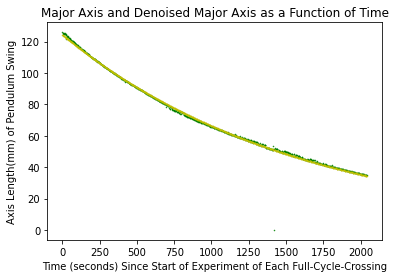

In [ ]:
#print(expt[0].time)
#print(expt[0].majaxis)
#print(expt[0].dnmajaxis)

time_o_crossing = expt[0].time
majaxis=expt[0].majaxis
dnmajaxis=expt[0].dnmajaxis

plt.plot(time_o_crossing, majaxis, 'go', markersize=.5, label='Major Axis')
plt.plot(time_o_crossing, dnmajaxis, 'yo', markersize=.5, label='Denoised Major Axis')
plt.ylabel('Axis Length(mm) of Pendulum Swing')
plt.xlabel('Time (seconds) Since Start of Experiment of Each Full-Cycle-Crossing')
plt.title('Major Axis and Denoised Major Axis as a Function of Time')
plt.show()


```trimExperiment(expt,timerange)``` will trim the experiment to a specific time range you indicate and then refit the data, for instance

```newexpt = trimExperiment(expt,(60,660))``` 

will return a new structure that has only the data from 60 seconds after the start of the experiments to 660 seconds after the start

you can use ```trimExperiment``` to clean off any ugly bits at the start or end of the experiment if you need to. 

Use ```trimExperiment``` to create a new experiment structure (```newexpt```) containing the middle 10 minutes (from 300 to 900 seconds) of your chosen experiment (e.g. ```expt[0]```), and plot the major axis and denoised major axis vs. time as before 

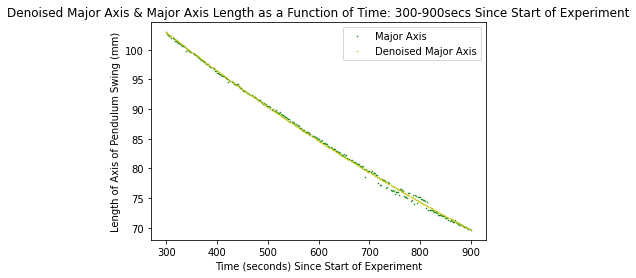

In [ ]:
newexpt = trimExperiment(expt[0],(300,900))
#print(newexpt.time)
#print(newexpt.majaxis)
#print(newexpt.dnmajaxis)
#print(type(newexpt.time))

newexpt.time = newexpt.time+300 #to line up the time and indicate this is starting from 300th second after experiment started, to the 899th second)

plt.plot(newexpt.time, newexpt.majaxis, 'go', markersize=.5, label='Major Axis')
plt.plot(newexpt.time, newexpt.dnmajaxis, 'yo', markersize=.5, label='Denoised Major Axis')
plt.legend(loc='upper right')
plt.ylabel('Length of Axis of Pendulum Swing (mm)')
plt.xlabel('Time (seconds) Since Start of Experiment')
plt.title('Denoised Major Axis & Major Axis Length as a Function of Time: 300-900secs Since Start of Experiment')
plt.show()


#OK here is where you start doing all the work!

```np.gradient``` estimates the derivative of a function using second order accurate differences

$g_i = 0.5 * (f_{i + 1} - f_{i-1})$

except at the boundaries

$g_0 = f_1 - f_0$ and $g_{n-1} = g_{n-1} - g_{n-2}$

The chief advantage of using ```np.gradient``` over ```np.diff```, which just takes the difference between successive points is that ```np.grad``` returns an array that's the same size as the original array

For a dataset of your choice:

1. Trim the experiment if you need to in order to remove problematic starts or ends
1. Calculate the period by taking the gradient of the crossing time (e.g. ```np.gradient(expt[0].time)```)
1. Plot the period vs. time
1. If there are outliers (e.g. due to a missed crossing, you get a period of 3 seconds instead of 2 seconds), then remove them as follows:
  1. Calculate the median period using ```np.median```
  2. Find all the periods within 10 ms of the median value (```valid = np.abs(period - medianperiod) < 0.01```)
  3. Create new time, amplitude, and period variables using only the `valid' values
    
       1. ```time = expt[0].time[valid]```
       1. ```dnamplitude = expt[0].dnamplitude[valid]```
       1.  etc.
  1. Plot the period vs. time for the valid data on a new set of axes 


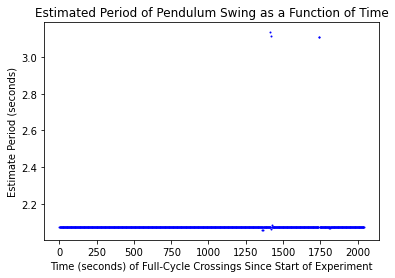

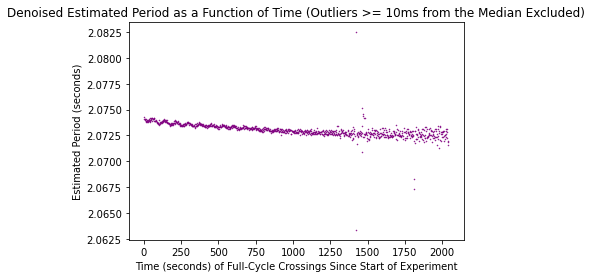

I trimmed the data to just the first 20minutes of the experiment


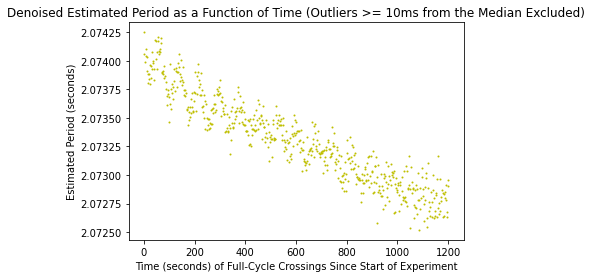

In [ ]:
period_estimate = np.gradient(expt[0].time)

#3: plot period vs CROSSING time as time?
plt.plot(expt[0].time, period_estimate, 'bo', markersize=1)
plt.ylabel('Estimate Period (seconds)')
plt.xlabel('Time (seconds) of Full-Cycle Crossings Since Start of Experiment')
plt.title('Estimated Period of Pendulum Swing as a Function of Time')
plt.show()

#4
median_period = np.median(period_estimate)
valid = np.abs(period_estimate - median_period) < 0.01
denoised_period = period_estimate[valid]
denoised_time = expt[0].time[valid]
denoised_dnamplitude = expt[0].dnamplitude[valid]

#4.4
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html Python Plot Things
plt.plot(denoised_time, denoised_period, color='purple', marker='.', linestyle='', markersize=1)
plt.ylabel('Estimated Period (seconds)')
plt.xlabel('Time (seconds) of Full-Cycle Crossings Since Start of Experiment')
plt.title('Denoised Estimated Period as a Function of Time (Outliers >= 10ms from the Median Excluded)')
plt.show()

#I'm going to try something
expt_20min = trimExperiment(expt[0],(0,1202))
period_est_20min = np.gradient(expt_20min.time)
median_period_20min = np.median(period_est_20min)
valid=np.abs(period_est_20min - median_period_20min) < 0.01
dn_time_20min = expt_20min.time[valid]
dn_period_est_20min = period_est_20min[valid]
print("I trimmed the data to just the first 20minutes of the experiment")
plt.plot(dn_time_20min, dn_period_est_20min, 'yo', markersize=1)
plt.ylabel('Estimated Period (seconds)')
plt.xlabel('Time (seconds) of Full-Cycle Crossings Since Start of Experiment')
plt.title('Denoised Estimated Period as a Function of Time (Outliers >= 10ms from the Median Excluded)')
plt.show()


Test the prediction $T = T_0(1 + \frac{1}{16} \frac{a^2}{L^2})$

If your data had outliers in the periods, then use the dataset with the outliers removed that you calculated above

1. Calculate $L$ **in mm** using $g = 9802$ mm/s$^2$ and the median period from your measurements above
1. Calculate $a^2/L^2$ using the denoised amplitude (which is also in mm)
1. Use ```np.polyfit``` to fit the period to an equation of the form $T = T_0 + m*a^2/L^2$ (note that if you store the result as ```p = np.polyfit(...```, then ```p[0]``` is m and ```p[1]``` is $T_0$.
1. According to our model, $T_0/m$ should equal 16. Print your result for this value
1. Do a 1 parameter fit to the model prediction $T = T_0(1 + \frac{1}{16} a^2/L^2)$. 
  1. Since $\frac{1}{16} a^2/L^2 \ll 1$, you can write $T_0 = T(1 - \frac{1}{16} a^2/L^2)$
  1. The average value of $T(1 - \frac{1}{16} a^2/L^2)$ is therefore the best estimate of $T_0$. 
  1. Use this best estimate to find the predicted period $T = T_0(1 + \frac{1}{16} a^2/L^2)$
1. Plot the period vs. time, the value of the period from the np.polyfit result vs. time, and the value from the one-parameter fit, on the same axes
1. Add a legend to the plot that says "data," "$T = \_\_(1 + {1}/{\_\_} \;\; a^2/L^2)$," and "model". Fill in the blanks using your fit results to 3 significant digits.
1. On a second figure, plot the residuals (period - your polyfit result) vs. time. ylabel `residuals', xlabel 'time'
1. On a third figure, plot $T/T_0 - 1$ vs. $a^2/L^2$ along with the line predicted by your fit result. 
1. On a fourth figure, plot the residuals vs denoised amplitude. ylabel residuals, xlabel 'amplitude'
1. On a fifth figure, make a histogram of the residuals with 100 bins spaced evenly from -4 sigma to 4 sigma. Title it with the standard deviation (in mm, to 2 decimal places) of the residuals. 
1. Calculate a gaussian distribution at the location of the histogram bins using the mean (shoule be 0) and standard deviation of the residuals. Scale this distribution so that its sum is the same as the number of residuals. Plot this gaussian vs. the bins on the same axes as the histogram

Estimated L = 1067.2747123375661 mm
T0, m = 2.0724739256794704, 0.11640772724780277
T0/m = 17.803576916055537
1Parameter Fit avg. T0 = 


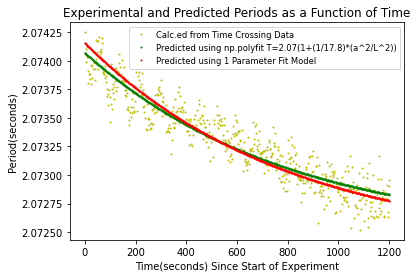

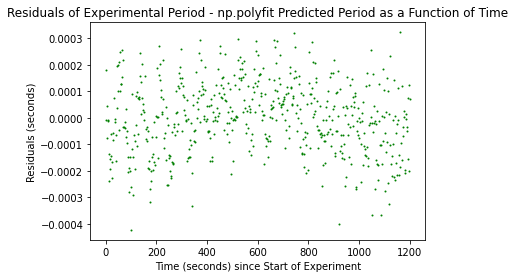

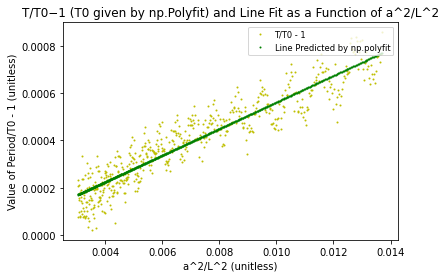

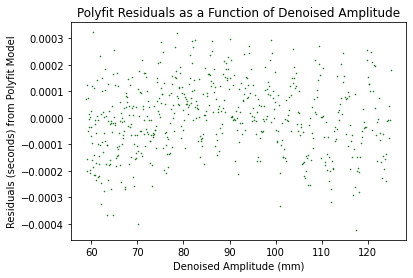

In [ ]:
L_median = 9802*(median_period_20min/(np.pi*2))**2
print("Estimated L = {} mm".format(L_median))
a = expt_20min.dnamplitude
a_Lsqr = (a**2)/(L_median**2)
'''
print(size(expt_20min.time))
print(size(a))
print(size(dn_period_est_20min))
#this shows me that the denoising I did for the last graph in part 4 in the above section didn't actually exclude any data
'''

p2 = np.polyfit(a_Lsqr, dn_period_est_20min, 1)
T0 = p2[1]
m = p2[0]
print('T0, m = {}, {}'.format(T0, m))
print('T0/m = {}'.format(T0/m))

'''
y = []
for i in range(580):
  y.append(median_period_20min)

plt.plot(a_Lsqr, dn_period_est_20min, 'go', markersize=1)
#plt.plot(a_Lsqr, y)
plt.show()
trying to figure out why our T is going down more quickly than expected as a function of a/L squared
'''
#WHY DO WE USE MEDIAN PERIOD TO CALCULATE THE LENGTH?

#5
List_T0 = dn_period_est_20min*(1-(1/16)*(a_Lsqr))
T0_avg = np.mean(List_T0)
print('1Parameter Fit avg. T0 = '.format(T0_avg))

#6
plt.plot(expt_20min.time, dn_period_est_20min, 'yo', markersize=1, label ='Calc.ed from Time Crossing Data')
plt.plot(expt_20min.time, T0*(1 + (m/T0)*a_Lsqr), 'go', markersize=1, label ='Predicted using np.polyfit T=2.07(1+(1/17.8)*(a^2/L^2))')
plt.plot(expt_20min.time, T0_avg*(1+(1/16)*(a_Lsqr)), 'ro', markersize=1, label ='Predicted using 1 Parameter Fit Model')
plt.legend(loc='upper right', fontsize='small')
plt.ylabel('Period(seconds)')
plt.xlabel('Time(seconds) Since Start of Experiment')
plt.title('Experimental and Predicted Periods as a Function of Time')
plt.show()

#8
plt.plot(expt_20min.time, dn_period_est_20min - T0*(1 + (m/T0)*a_Lsqr), 'go', markersize = 1)
plt.ylabel('Residuals (seconds)')
plt.xlabel('Time (seconds) since Start of Experiment')
plt.title("Residuals of Experimental Period - np.polyfit Predicted Period as a Function of Time")
plt.show()

# #9
# plt.plot(a_Lsqr, dn_period_est_20min/T0_avg - 1, 'yo', markersize=1, label='T/T0_avg - 1')
# plt.plot(a_Lsqr, (1/16)*(a_Lsqr), 'ro', markersize=1, label='Line Predicted by 1-Parameter Fit')
# plt.legend(loc='upper right', fontsize='small')
# plt.show()

#9 USING NP POLYFIT
plt.plot(a_Lsqr, dn_period_est_20min/T0 - 1, 'yo', markersize=1, label='T/T0 - 1')
plt.plot(a_Lsqr, (m/T0)*(a_Lsqr), 'go', markersize=1, label='Line Predicted by np.polyfit')
plt.legend(loc='upper right', fontsize='small')
plt.xlabel('a^2/L^2 (unitless)')
plt.ylabel('Value of Period/T0 - 1 (unitless)')
plt.title('T/T0−1 (T0 given by np.Polyfit) and Line Fit as a Function of a^2/L^2')
plt.show()

#10
plt.plot(a, dn_period_est_20min - T0*(1 + (m/T0)*a_Lsqr), color='darkgreen', linestyle='', marker='.',  markersize=1 )
plt.ylabel('Residuals (seconds) from Polyfit Model')
plt.xlabel('Denoised Amplitude (mm)')
plt.title('Polyfit Residuals as a Function of Denoised Amplitude')
plt.show()

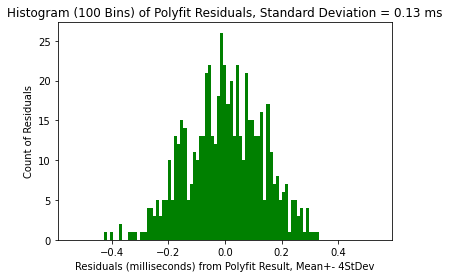

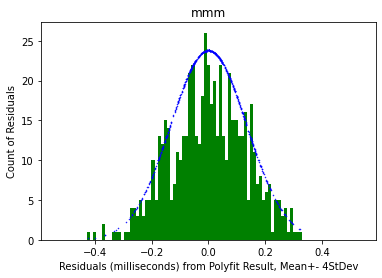

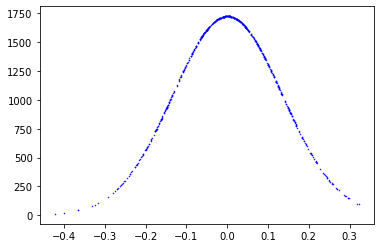

580


In [ ]:
# 11
# On a fifth figure, make a histogram of the residuals with 100 bins spaced evenly
# from -4 sigma to 4 sigma. Title it with the standard deviation 
# (in ms, to 2 decimal places) of the residuals.

#https://www.geeksforgeeks.org/python-statistics-stdev/
import statistics as st
residuals = dn_period_est_20min - T0*(1 + (m/T0)*a_Lsqr)
mean_residuals = np.mean(residuals)
stdv_residuals = st.stdev(residuals, mean_residuals)
r = np.linspace(mean_residuals-4*stdv_residuals, mean_residuals+4*stdv_residuals, 100)
r = r*1000
plt.hist(residuals*1000, bins=r, color='green')
plt.xlabel('Residuals (milliseconds) from Polyfit Result, Mean+- 4StDev')
plt.ylabel('Count of Residuals')
plt.title('Histogram (100 Bins) of Polyfit Residuals, Standard Deviation = {:.2} ms'.format(stdv_residuals*1000))
plt.show()



# 12
# Calculate a gaussian distribution 
# at the location of the histogram bins using the mean (shoule be 0) 
# and standard deviation of the residuals. 
# Scale this distribution so that its sum is the same as the number of residuals. 
# Plot this gaussian vs. the bins on the same axes as the histogram


res = residuals*1000
mean = np.mean(res)
s = st.stdev(res, mean)

plt.hist(residuals*1000, bins=r, color='green')

plt.plot(res, 8*(1/(s*np.sqrt(2*np.pi)))*((np.e)**(-0.5*((res-mean)/(s))**2)), color='blue', linestyle='',marker='.', markersize=1)

plt.xlabel('Residuals (milliseconds) from Polyfit Result, Mean+- 4StDev')
plt.ylabel('Count of Residuals')
plt.title('mmm')
plt.show()

plt.plot(res, 580*(1/(s*np.sqrt(2*np.pi)))*((np.e)**(-0.5*((res-mean)/(s))**2)), color='blue', linestyle='',marker='.', markersize=1)
plt.show()

#what does he mean by the distribution's sum is the same as the NUMBER of residuals...?
print(size(res))
#The area under my gaussian curve should be 580 then???



In [ ]:
print(s)

0.13418722807313913


if you have more than one data set, you can do them all without too much extra work,

```
for e in expt:
  #all the code you wrote before, just change expt[0] to e
  plt.show()
  ```


#QUESTIONS

1. To what extent are your data consistent/inconsistent with the simulation you did last week? How does your fit to the data agree with/differ from the one-parameter model fit?
**Answer:**
-Yes, I think my data from this lab are consistent with Simulation 1, in which we find that the period of a pendulum actually deviates (increases) by a factor of (1/16)*(amplitude/pendulum length)^2, as the amplitude of a pendulum increases. Maybe it is due to experimental errors, but from my polyfit, my data are better fitted with the equation of T = T0(1 - (1/17.8)(a/L)^2), rather than the multiplier to (a/L)^2 being (1/16). 

My polyfit line and my one-paramenter fit model basically overlap each other. For some reason, the one-parameter fit model starts off slightly over-predicting my data, and then under-predicts it slightly in the end as the experimental time increases. I think this is because I calculated the value of T0 based off of (1/16)(a/L)^2, so the slope of the one-parameter fit model is steeper downwards, and T0, as a result, started off being a larger positive value.

2. Based on your observation of the temporal structure and the histogram of the residuals, do you think these errors can be modeled as independent gaussian noise?
**Answer:**
Yes, because my residuals are normally distributed. The histogram of the residuals can be modeled by a Gaussian curve using the mean of the residuals and the variance of the residuals with intergrated area of 1. That means that the errors are most likely independent and normally distributed.

3. If you did multiple experiments, how much do the fit parameters vary between measurements? Would it surprise you more to find that $T_0$ varied or that $T_0/m$ varied?
**Answer:** We did not do multiple experiments (or at least I didn't analyze all but one of them...), but I would be more surprised to find that $T_0/m$ varied. Because $T_0/m$ is a ratio that describes, essentially, the *shape* or slope of the fit, and we know that no matter what, the period should always descrease as amplitude decreases with time. However, $T_0$ itself might change due to slight errors across multiple trials of the experiment (i.e. the length is the pendulum got changed, there was some systematic error influencing all the periods, etc.).

4. I would argue that the denoised amplitude has very little error. Would you agree or disagree? Why? Why can't we do a similar denoising on the period?
**Answer:** Yes, I agree that the denoised amplitude has very little error. I think it's because we are doing the experiment *over time*, and there aren't really any effects (that I can think of) which influences the pendulum's relative position to the board unevenly over time. Therefore, the denoised amplitude plot looks almost like a smooth line.

However, for some reason, the measured periods decreased in a 'zig zag' pattern over time. And since all factors that affect the pendulum's position (amplitude) therefore affect where/when it crosses the center of the magnet (crossing time) simultaenously, we cannot denoise the period *on top of* denoising the amplitude... That's my best answer.

